# Global Statistics

To accelerate the runtime, here we only load the first 100 samples from the previous `05a_inverse_global_opt.ipynb`. Using variable `df_test_100`

In order to reproduce the results in our paper, use `df_test` (containing all 2500 samples).

**Note**

`df_test (2500 samples)`

`df_test_100 (100 samples)`

## Import Module

In [1]:
import tensorflow as tf
import pandas as pd
import ast
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import pymiecs

2025-03-19 13:37:40.474786: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 13:37:40.483109: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-19 13:37:40.493429: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-19 13:37:40.495958: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 13:37:40.502759: I tensorflow/core/platform/cpu_feature_guar

## Set dynamic GPU memory growth

In [2]:
# Check if GPU available
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and set to memory growth mode.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected by TensorFlow.")

GPU is available and set to memory growth mode.


I0000 00:00:1742387862.327579   69036 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742387862.350004   69036 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742387862.351390   69036 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## Load runtime

In [3]:
with open("runtime/global_inverse_runtime.pkl", "rb") as f:
    loaded_runtimes = pickle.load(f)

loaded_runtimes.head()

,Sample,Runtime (seconds)
0,1,4.338133
1,2,4.323697
2,3,3.205805
3,4,4.147974
4,5,4.145138


In [4]:
# Sum the 'Runtime (seconds)' column
total_runtime = loaded_runtimes["Runtime (seconds)"].sum()
avr_runtime = loaded_runtimes["Runtime (seconds)"].mean()


print("Total Runtime (seconds):", total_runtime)
print("Total avr_runtime (seconds):", avr_runtime)

Total Runtime (seconds): 407.650514125824
Total avr_runtime (seconds): 4.07650514125824


## Load test data and best geometries from global opt

In [5]:
hdf5_df_file = "datasets/core_shell_particles_raw_122500_test_with_pred.h5"
df_test = pd.read_hdf(hdf5_df_file)     # 2500 samples
df_test_100 = df_test.head(100)         # 100 samples

with open("best_geometries/global_inverse_test_data.pkl", "rb") as f:
    best_df = pickle.load(f)

best_df.head()

,mat_core,mat_shell,r_core,r_shell,Sample Index,Runtime (seconds),Loss,mie_Qfwd,mie_Qback,predicted_Qfwd,predicted_Qback,log_Qfwd,log_Qback
0,ZrO2,Au,77.337858,103.499478,1,4.338133,0.130269,"[7.943693523704477, 7.631676005310999, 7.35065...","[0.12938060934056017, 0.20866880941269564, 0.2...","[8.072288513183594, 6.878783226013184, 5.89059...","[0.33133822679519653, 0.38059815764427185, 0.4...","[2.1909486496924258, 2.1554386931122766, 2.122...","[0.1216693491173211, 0.1895195964809834, 0.262..."
1,SiO2,Au,65.444002,84.980111,2,4.323697,0.005362,"[2.6381263938781765, 2.5292054290052843, 2.427...","[0.33209261045765476, 0.3435998575540038, 0.35...","[2.338696002960205, 2.1593070030212402, 2.0634...","[0.7892377376556396, 0.72929847240448, 0.54657...","[1.291468822174709, 1.261072754675092, 1.23169...","[0.2867510970718935, 0.29535247273783766, 0.30..."
2,Si,Si,48.419073,31.936499,3,3.205805,0.000001,"[1.137715927515656, 0.8148088614955376, 0.6078...","[0.11457456575332535, 0.03793865784512998, 0.0...","[1.4390088319778442, 1.7832248210906982, 1.866...","[1.8866853713989258, 1.9344102144241333, 1.591...","[0.7597379354475057, 0.5959801517004989, 0.474...","[0.10847277672312375, 0.037236686509116546, 0...."
3,ZrO2,Si3N4,93.356095,117.463630,4,4.147974,0.002124,"[20.180305365698967, 17.00894306872726, 14.976...","[1.502571295840774, 1.187915005201223, 1.03181...","[15.712120056152344, 13.141104698181152, 12.28...","[1.2991472482681274, 1.1873573064804077, 1.035...","[3.053071757713282, 2.8908684716649673, 2.7711...","[0.9173187216478738, 0.7829490379191183, 0.708..."
4,Au,TiO2,49.023123,77.253263,5,4.145138,0.008713,"[6.220173089120092, 6.539505428696962, 6.85150...","[1.9077666986221749, 1.8125993548908415, 1.691...","[5.192962646484375, 5.916505813598633, 6.53437...","[2.2177658081054688, 2.3039534091949463, 2.199...","[1.9768789261797133, 2.020156586857536, 2.0607...","[1.0673853290189652, 1.0341090930899939, 0.990..."


## Statistics

In [6]:
# Convert relevant columns from DataFrame to NumPy arrays
qfwd_target = np.vstack(df_test_100["Q_fwd"])   # use df_test if you optimized 2500 samples from previous script `05a`
qfwd_mie = np.vstack(best_df["mie_Qfwd"])

qback_target = np.vstack(df_test_100["Q_back"]) # use df_test if you optimized 2500 samples from previous script `05a`
qback_mie = np.vstack(best_df["mie_Qback"])

# Calculate performance metrics
mse_Qfwd = np.abs(qfwd_target - qfwd_mie) ** 2
mae_Qfwd = np.abs(qfwd_target - qfwd_mie)

mse_Qback = np.abs(qback_target - qback_mie) ** 2
mae_Qback = np.abs(qback_target - qback_mie)

# Print the results
print(f"Inverse Design Performance for Qfwd:")
print(f"Mean Absolute Error (MAE): {mae_Qfwd.mean():.6f}")
print(f"Mean Squared Error (MSE): {mse_Qfwd.mean():.6f}")

print(f"\nTest Set Performance for Qback:")
print(f"Mean Absolute Error (MAE): {mae_Qback.mean():.6f}")
print(f"Mean Squared Error (MSE): {mse_Qback.mean():.6f}")

Inverse Design Performance for Qfwd:
Mean Absolute Error (MAE): 0.518669
Mean Squared Error (MSE): 2.611965

Test Set Performance for Qback:
Mean Absolute Error (MAE): 0.276746
Mean Squared Error (MSE): 0.976175


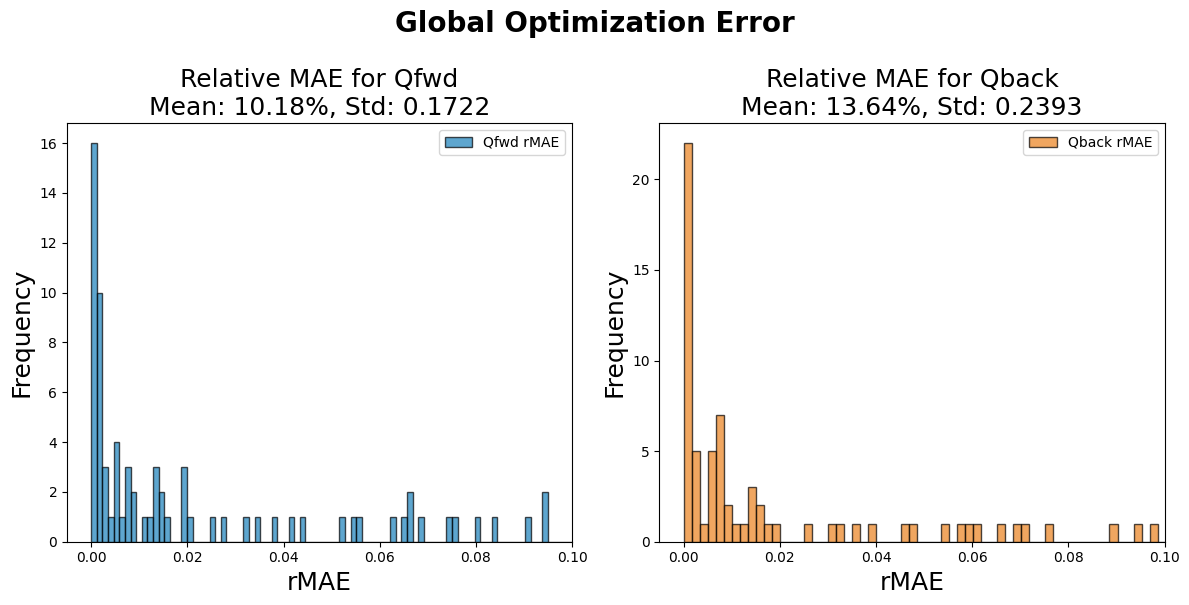

In [7]:
# Absolute percentage error (MAPE)
mape_Qfwd = mae_Qfwd.mean(axis=1) / qfwd_target.mean()
mape_Qback = mae_Qback.mean(axis=1) / qback_target.mean()

# Plot histograms of MAE for Qfwd and Qback
plt.figure(figsize=(12, 6))
plt.suptitle("Global Optimization Error", fontweight="bold", fontsize=20, y=1.00)

# Plot the Qfwd MAE distribution
plt.subplot(1, 2, 1)
plt.hist(
    mape_Qfwd,
    bins=700,
    color="#1a80bbff",
    label="Qfwd rMAE",
    edgecolor="black",
    alpha=0.7,
)
plt.title(
    f"Relative MAE for Qfwd\nMean: {100*mape_Qfwd.mean():.2f}%, Std: {mape_Qfwd.std():.4f}",
    fontsize=18,
)
plt.xlabel("rMAE", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.legend()
plt.xlim([-0.005, 0.1])

# Plot the Qback MAE distribution
plt.subplot(1, 2, 2)
plt.hist(
    mape_Qback,
    bins=700,
    color="#ea801cff",
    label="Qback rMAE",
    edgecolor="black",
    alpha=0.7,
)
plt.title(
    f"Relative MAE for Qback\nMean: {100*mape_Qback.mean():.2f}%, Std: {mape_Qback.std():.4f}",
    fontsize=18,
)
plt.xlabel("rMAE", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.legend()
plt.xlim([-0.005, 0.1])

plt.tight_layout()
plt.show()

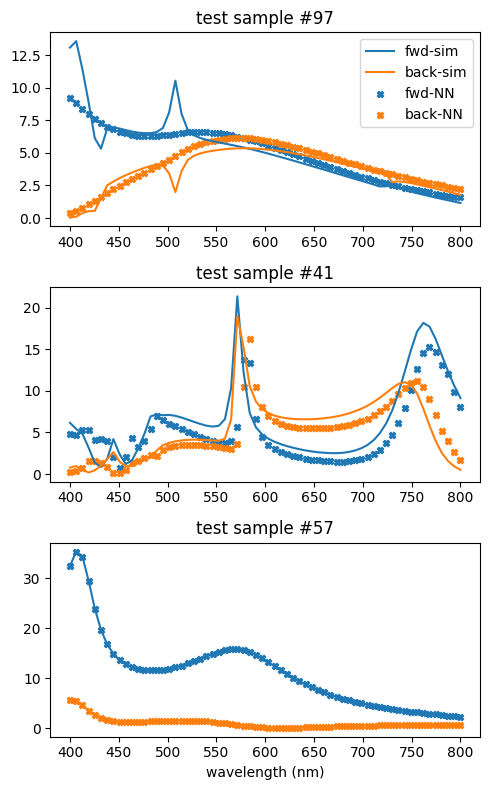

In [8]:
plt.figure(figsize=(5, 8))
for i, d in enumerate(np.random.choice(len(df_test_100), 3)): # use df_test if you optimized 2500 samples from previous script `05a`
    plt.subplot(3, 1, i + 1, title=f"test sample #{d}")
    plt.plot(df_test_100["wavelength"][d], df_test_100["Q_fwd"][d], label="fwd-sim")
    plt.plot(df_test_100["wavelength"][d], df_test_100["Q_back"][d], label="back-sim")
    plt.scatter(
        df_test_100["wavelength"][d],
        best_df["mie_Qfwd"][d],
        label="fwd-NN",
        marker="X",
        s=20,
    )
    plt.scatter(
        df_test_100["wavelength"][d],
        best_df["mie_Qback"][d],
        label="back-NN",
        marker="X",
        s=20,
    )
    if i == 0:
        plt.legend()
    if i == 2:
        plt.xlabel("wavelength (nm)")

plt.tight_layout()
plt.show()